In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path

from bgspy.tree_utils import load_recrates, load_neutregions
from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment, bgs_segment_sc16
from bgspy.classic import BSC16_segment_lazy

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

TODO

 - nans in low rec causing issue?
 - Neh vs Ne

In [4]:
force = True

### bgspy B maps

In [5]:
w_grid = np.array([1e-10, 3.16e-10, 1e-9, 3.16e-9, 1e-8, 3.16e-8])
t_grid = np.array([0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1])

pkl_b_file = '../data/bmaps/bgspy/B_chr10_all.pkl'
step = 1_000

In [6]:
if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
    g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=step, ncores=70, nchunks=200)
    m.calc_B(step=step, ncores=70, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
calculating SC16 components...	done.
Genome divided into 200 chunks to be processed on 70 CPUs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [41:20<00:00, 12.40s/it]


Genome divided into 70 chunks to be processed on 70 CPUs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [07:16<00:00,  6.24s/it]


In [16]:
bp = m.BpScores
b = m.BScores

### `calc_bkgd` maps

In [17]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


In [18]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/chr10_B_sims.npz', allow_pickle=True)

In [19]:
mus = sim_B['mu']
shs = sim_B['sh']

In [20]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [21]:
simb_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

In [22]:
sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': simb_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': simb_pos}, mus, shs, step=None)

In [23]:
from bgspy.utils import bin_chrom
bin_chrom(g.seqlens['chr10'], 1000)

array([        0,      1000,      2000, ..., 133796000, 133797000,
       133797421], dtype=uint32)

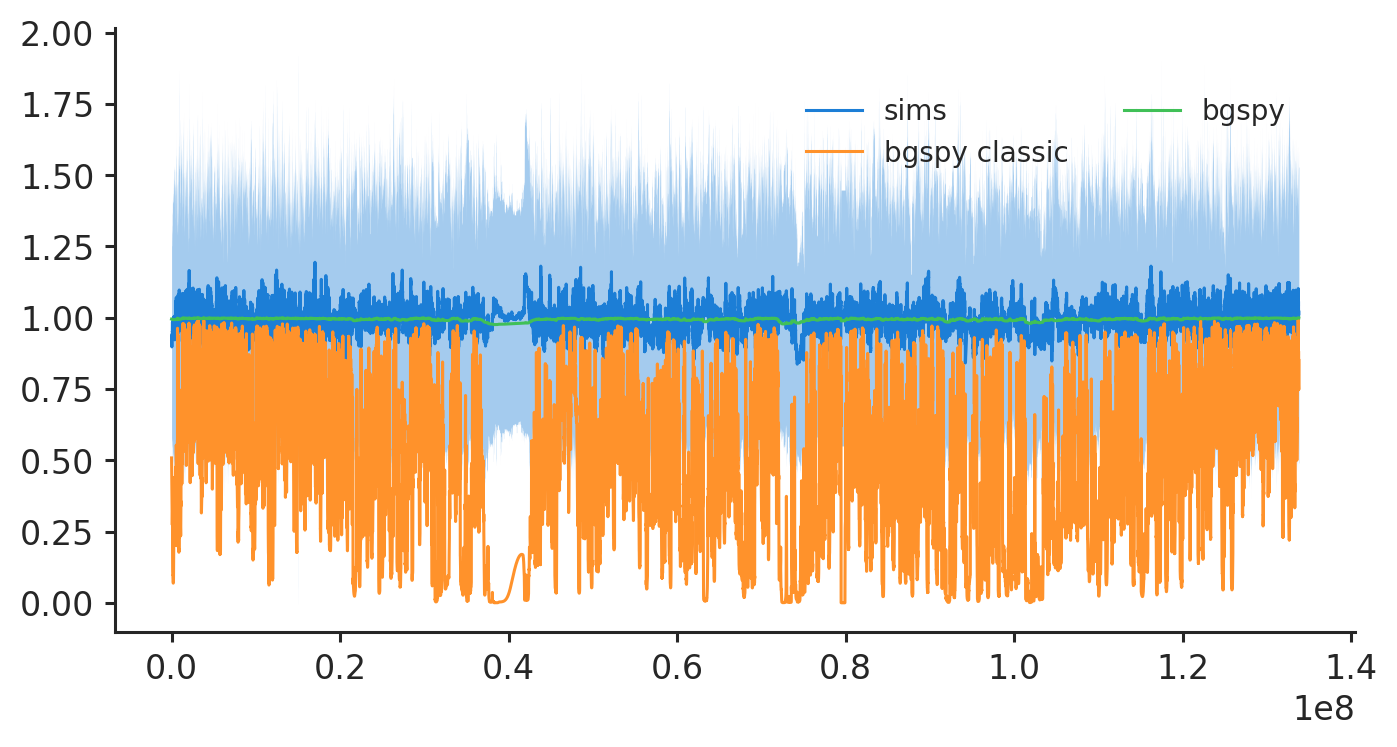

In [202]:
sh = 0.0001
mu = 3.16e-9


lines = plt.plot(*sims_means['chr10', mu, sh], label='sims')
sim_pos, sd = sims_sds['chr10', mu, sh]
_, mean = sims_means['chr10', mu, sh]
plt.fill_between(sim_pos, mean - sd, mean + sd, alpha=0.4, 
                 linewidth=0, color=lines[0].get_color())

plt.plot(*b['chr10', mu, sh], label='bgspy classic', zorder=2)
plt.plot(*bp['chr10', mu, sh], label='bgspy')

plt.legend(ncol=2)


building interpolators...		done.
building interpolators...		done.


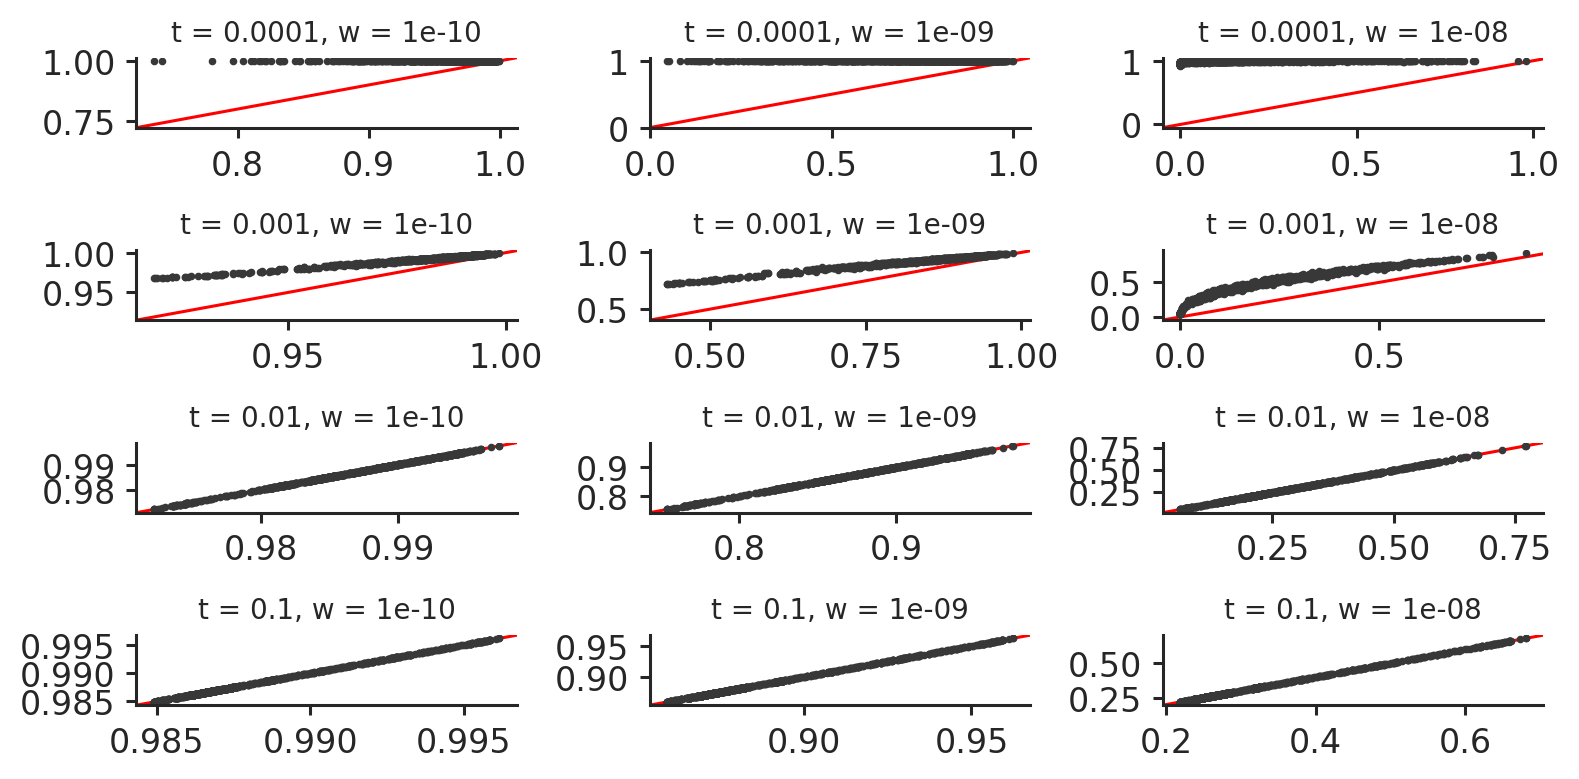

In [26]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sim_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


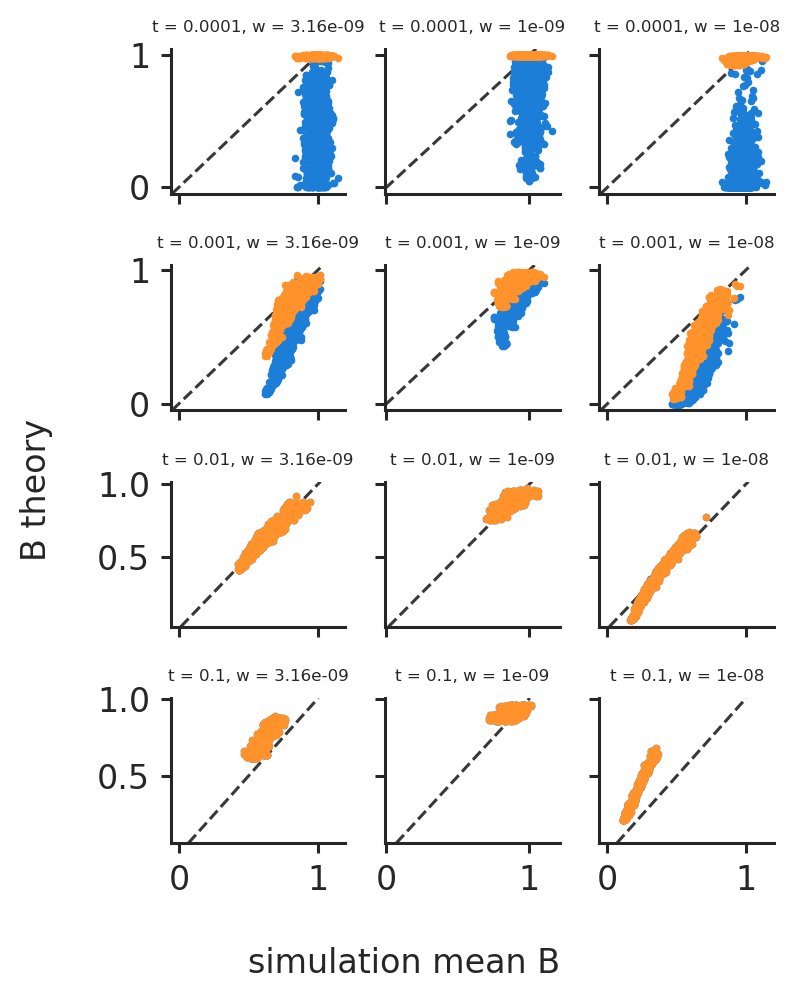

In [30]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, y, s=3)
    ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

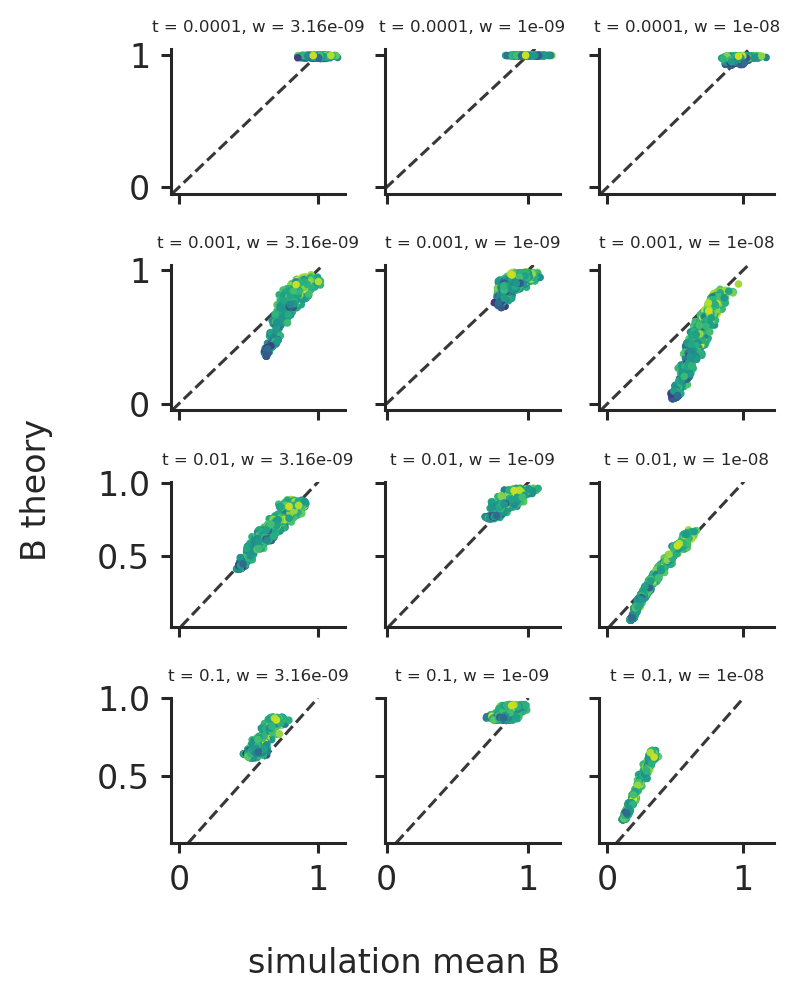

In [66]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [153]:
from bgspy.utils import load_bed_ranges
from bgspy.plots import surface_plot, chrom_plot

In [86]:
f = "../data/chrombgs_chr10_N1000_mu1e-08_sh0.001_chr10_seed1001729303_rep17_dac.tsv.gz"

m.load_dacfile(f, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [165]:
pi0 = 4*1000*1.5e-8
pi0

5.9999999999999995e-05

In [110]:
llc, pi0c = m.loglikelihood(pi0=4*1000*1.5e-8, method='classic')

In [80]:
ll, pi0 = m.loglikelihood(pi0=4*1000*1.5e-8)

In [151]:
np.sum(ll, axis=0).shape, m.w.shape, m.t.shape

((6, 7), (6,), (7,))

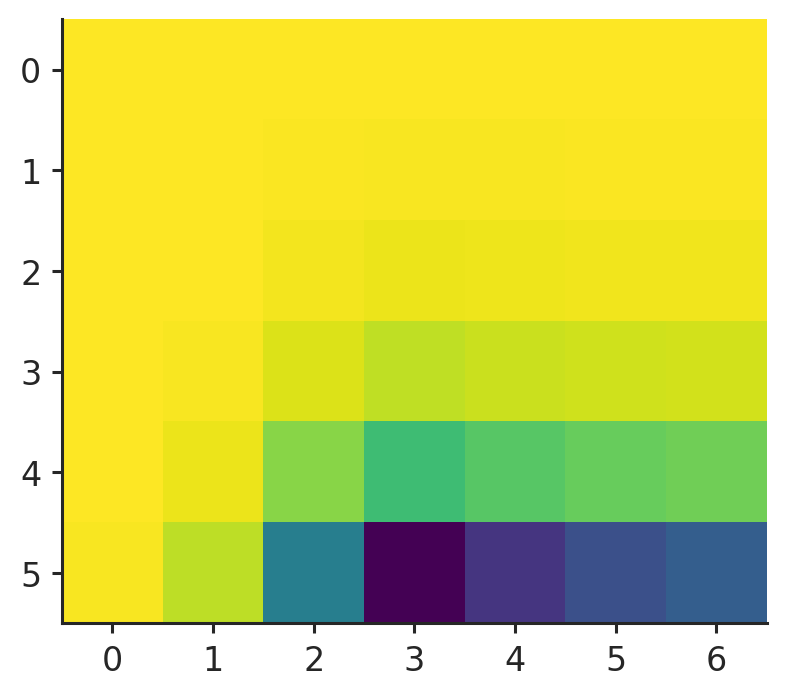

In [152]:
plt.imshow(np.sum(ll, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

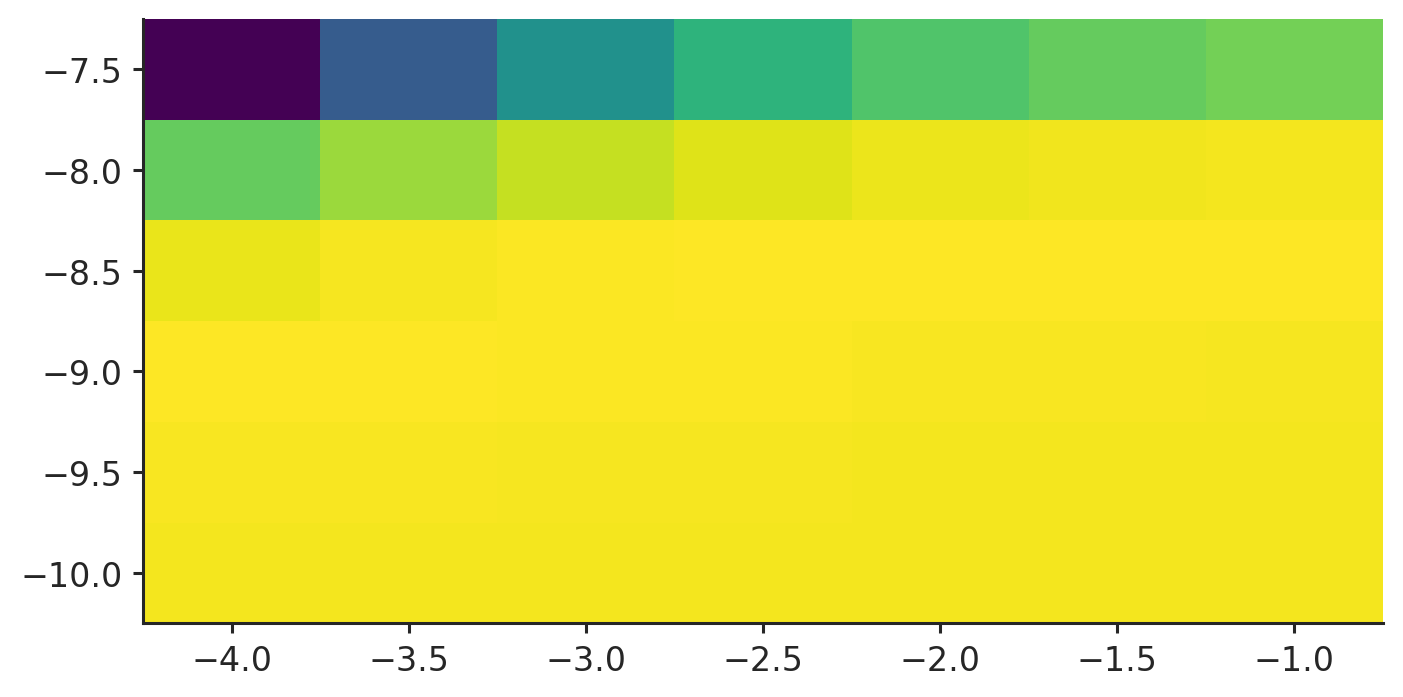

In [111]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

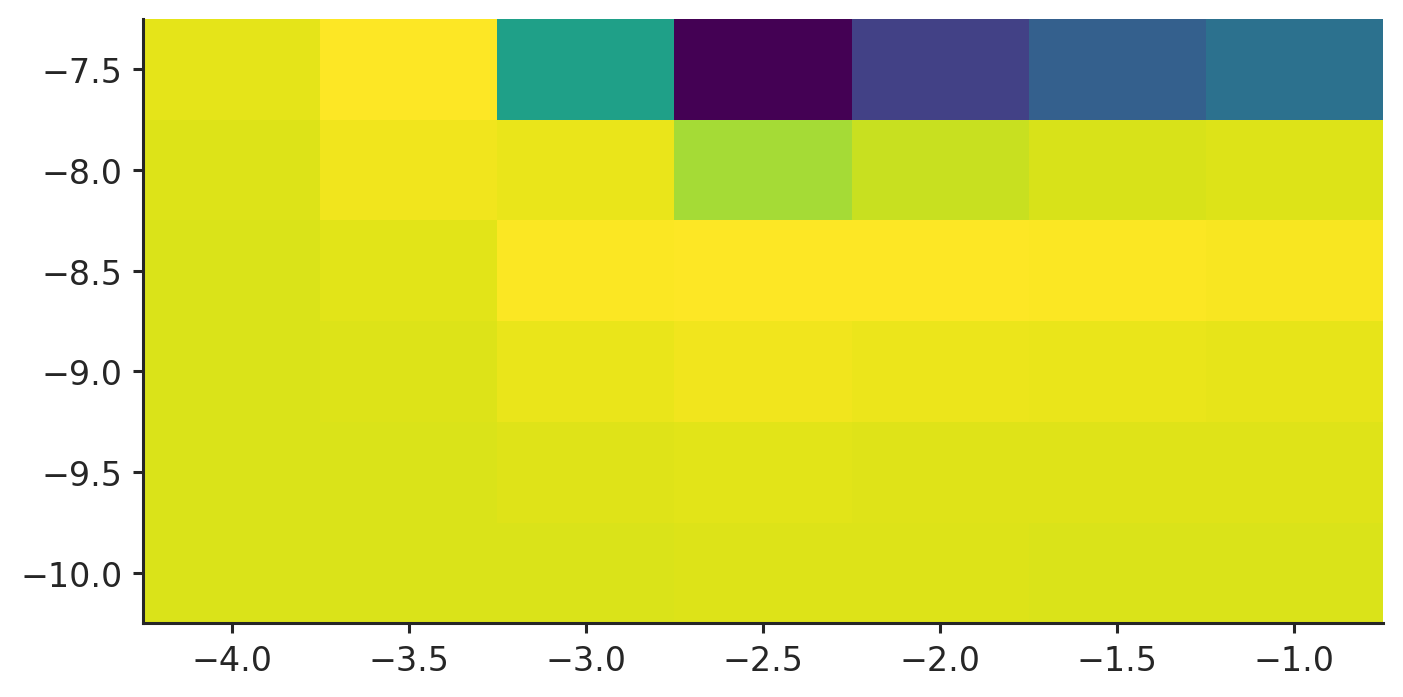

In [102]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [189]:
f2 = '../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_dac.tsv.gz'
m.load_dacfile(f2, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [190]:
pi0_grid = np.logspace(-5, -3, 20)

In [191]:
llc, pi0c = m.loglikelihood(pi0_grid=pi0_grid, method='classic')
ll, pi0 = m.loglikelihood(pi0_grid=pi0_grid, )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

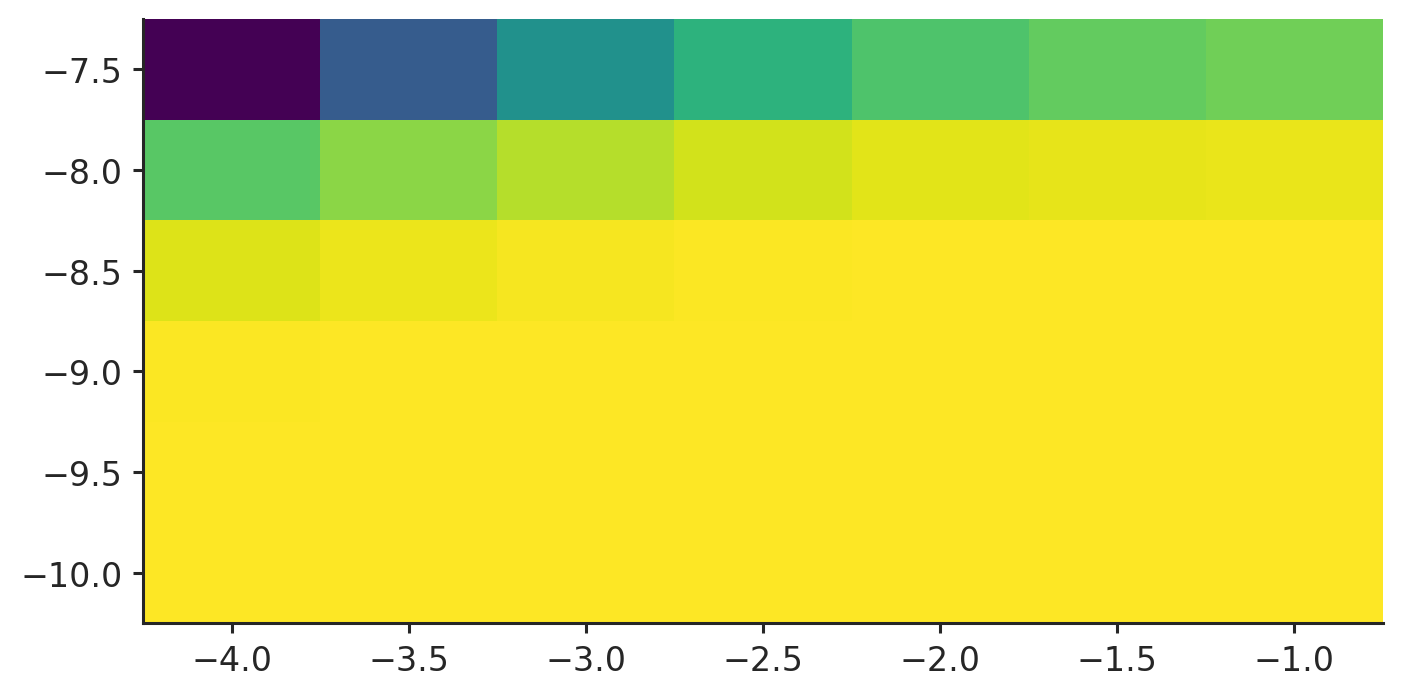

In [192]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

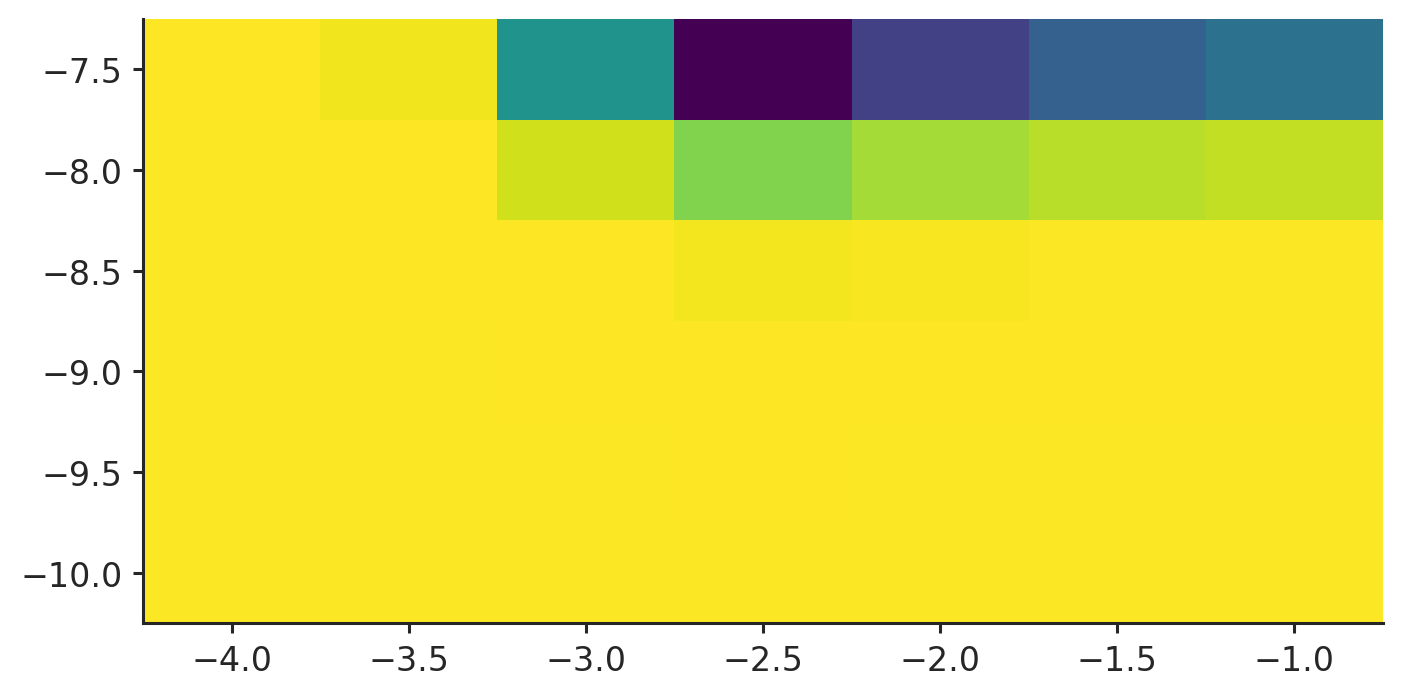

In [193]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [194]:
pi0, pi0c

(6.951927961775606e-05, 6.951927961775606e-05)

In [195]:
from bgspy.utils import bin_chrom
import tskit
ts = tskit.load('../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_treeseq.tree')

In [196]:
bins = bin_chrom(ts.sequence_length+1, 100_000)
ts.diversity(windows=bins, mode='branch')

array([4548.52592019, 3008.03712833, 2716.08040074, ..., 3721.87106787,
       5143.73376538, 3547.17702718])

In [197]:
np.where(ll.sum(axis=0) == np.max(ll.sum(axis=0)))

(array([4]), array([1]))

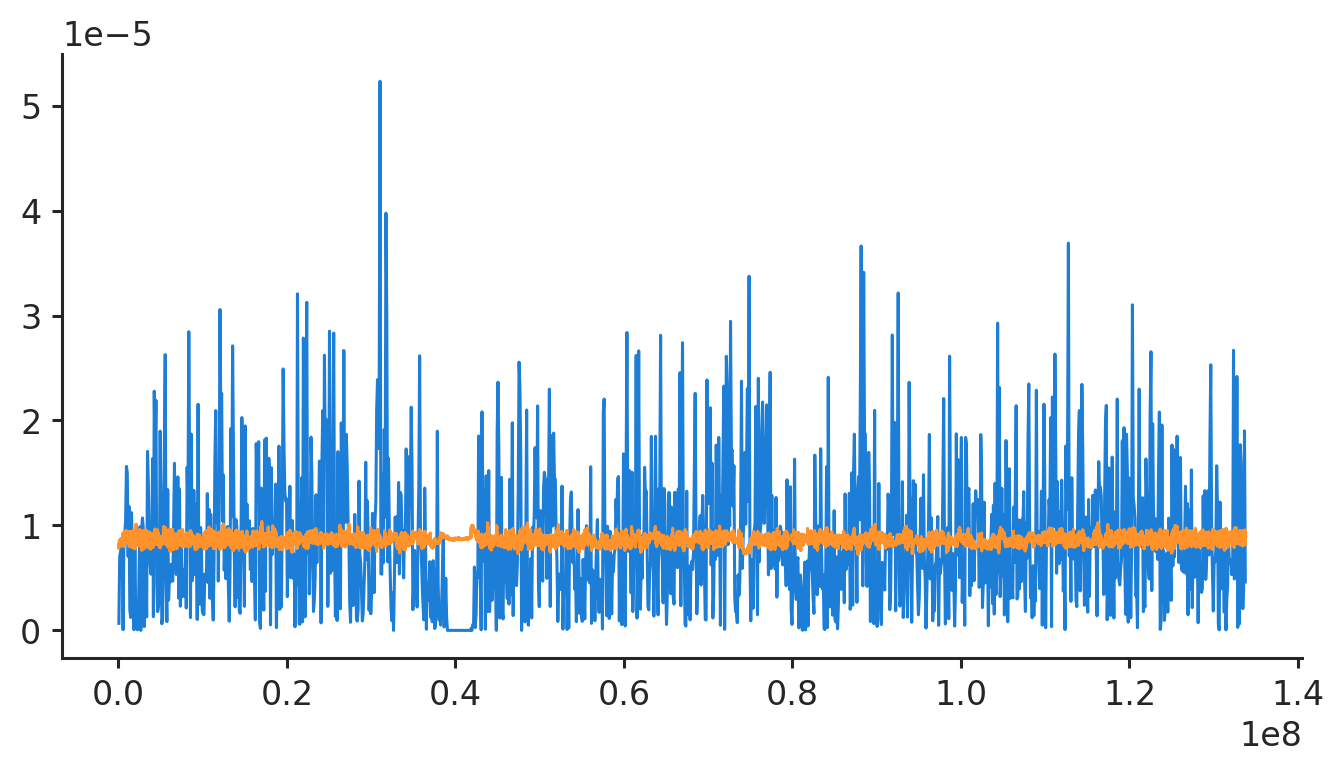

In [208]:
mu = m.w[3]
sh = m.t[0]
x, y = bp['chr10', mu, sh]

plt.plot(0.5*(bins[1:] + bins[:-1]), ts.diversity(windows=bins))
#plt.plot(x, y * pi0)
x, y = sims_means['chr10', mu, sh]
plt.plot(x, y*pi0/8)

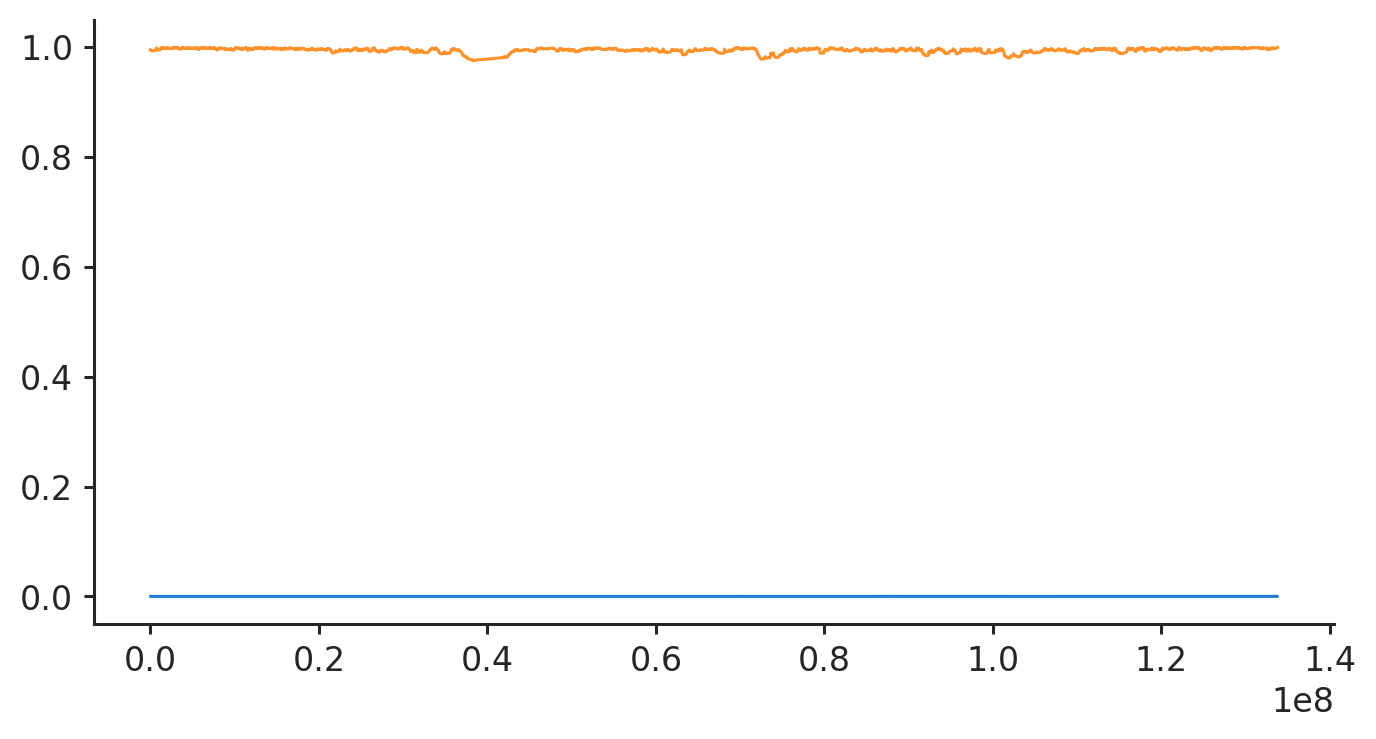

In [204]:
mu = m.w[3]
sh = m.t[0]
x, y = bp['chr10', mu, sh]

plt.plot(0.5*(bins[1:] + bins[:-1]), ts.diversity(windows=bins))
plt.plot(x, y)

In [188]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [170]:
ts.diversity()

array(8.64303173e-06)

In [155]:
chrom_plot(m.loglikelihood(pi0=pi0), 'chr10')

ValueError: not enough values to unpack (expected 15, got 2)